# Dataset

https://www.kaggle.com/uciml/sms-spam-collection-dataset

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re, string, unicodedata
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package stopwords to /home/ilya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ilya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Plots functions

Создадим вспомогательные методы для отображения различных кривых и метрик предсказания.

In [2]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid()

In [3]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.grid()

In [4]:
def print_stats(y_test, y_pred):    
    print("Confusion Matrix: \n", metrics.confusion_matrix(y_test,y_pred))
    print("Classification Report: \n", metrics.classification_report(y_test, y_pred))
    print("Accuracy: {:.2f}%".format(100 * metrics.accuracy_score(y_test, y_pred)))
    print("Precision: {:.2f}%".format(100 * metrics.precision_score(y_test, y_pred)))
    print("Recall: {:.2f}%".format(100 * metrics.recall_score(y_test, y_pred)))

# Upload data

In [5]:
df = pd.read_csv('spam.csv', encoding='latin-1')

In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df.shape

(5572, 5)

Почистим:

In [8]:
df = df.rename({'v1': 'mark', 'v2': 'message'}, axis=1)
df = df[['mark', 'message']]
df.mark = df.mark.apply(lambda mark : 0 if mark == 'ham' else 1)

In [9]:
df.head()

,mark,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Посмотрим, что нам может пригодиться. В первую очередь - длина сообщения и какие-то ключевые слова.

In [10]:
df['message_length'] = df.message.apply(lambda message: len(message.split(' ')))

In [11]:
df.head()

,mark,message,message_length
0,0,"Go until jurong point, crazy.. Available only ...",20
1,0,Ok lar... Joking wif u oni...,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,0,U dun say so early hor... U c already then say...,11
4,0,"Nah I don't think he goes to usf, he lives aro...",13


In [12]:
df.corr()

,mark,message_length
mark,1.000000,0.285458
message_length,0.285458,1.000000


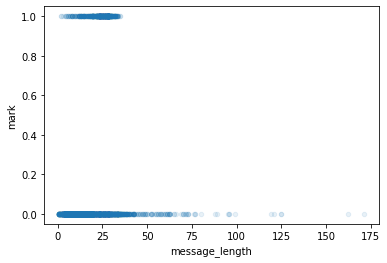

In [13]:
df.plot(kind="scatter", x="message_length", y="mark", alpha=0.1)
None

Вывод: спам как правильно более короткий.

Прежде чем искать слова сделаем обработку данных

# Preprocessing

Выкинем всё скобочки, адреса, пунктуацию, переносы строк, слова с числами; оставим по 1 пробелу между словами в сообщение

In [14]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\] | <.*?>+', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(' +', ' ', text)
    return text

In [15]:
df['message'] = df.message.apply(clean_text)

In [16]:
df.head()

,mark,message,message_length
0,0,go until jurong point crazy available only in ...,20
1,0,ok lar joking wif u oni,6
2,1,free entry in a wkly comp to win fa cup final ...,28
3,0,u dun say so early hor u c already then say,11
4,0,nah i don t think he goes to usf he lives arou...,13


Выкинем артикли, разговорные сокращения и прочие служебные части речи.

In [17]:
stop_words = [*stopwords.words('english'), *['u', 'ur', 'lt', 'gt']]

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['message'] = df.message.apply(remove_stopwords)

Stemming (не хотим различать слова с разными окончаниями)

In [18]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df['message'] = df.message.apply(stemm_text)

Lemmatization (не хотим различать формы слова, например, степени прилагательных)

In [19]:
lemmatizer = WordNetLemmatizer()

def lemm_text(text):
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
    return text

df['message'] = df.message.apply(lemm_text)

Удалим выбросы по длине сообщения.

In [20]:
df = df.loc[df.message_length < 75]
df.shape

(5556, 3)

# KNN solution

Напишем пайплайн предобработки данных: достанем из train датасета топ 20 самых частых слов в spam и ham и добавим фичи "частота встречаемости слова в сообщении" для этих частых слов.

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class FreqAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return

    def fit(self, X, y=None):
        train = pd.DataFrame(X_train.copy())
        train['mark'] = y_train
        
        self.top_ham_words = self.get_top_words(20, train[train.mark == 0].message)
        self.top_spam_words = self.get_top_words(20, train[train.mark == 1].message)
        self.top_spam_words = list(set(self.top_spam_words) - set(self.top_ham_words))
        
        train = train.drop(['mark'], axis=1)
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        
        for word in self.top_ham_words + self.top_spam_words:
            df[f'word_freq_{word}'] = df.message.apply(lambda message: message.split(' ').count(word) / len(message.split(' ')))
        
        df = df.drop(['message'], axis=1)
            
        return df
        
    def get_top_words(self, n, messages):
        all_words = ' '.join(messages).split()
        counter = Counter(all_words)
        return [t[0] for t in counter.most_common(n)]

In [22]:
pipeline = Pipeline([('add_attr', FreqAttributesAdder()),
                     ('scaler', StandardScaler())])

full_pipeline = Pipeline([('pipeline', pipeline),
                          ('knn', KNeighborsClassifier())])

Ну всё, давайте делать KNN. Очевидно, что в задаче классификации spam/ham мы хотим максимизировать precision: мы хотим, чтобы как можно меньше нормальных сообщений идентифицировались как спам. Если спам распознается как нормальное сообщение, то это не сильно страшно.

In [23]:
X, y = df.drop(['mark'], axis=1), df.mark
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

params = {'knn__n_neighbors': range(1, 15), 'knn__metric': ['manhattan', 'euclidean'], 'knn__weights': ['uniform', 'distance']}

grid_pipeline = GridSearchCV(estimator=full_pipeline, param_grid=params, cv=5, scoring='precision', n_jobs=-1)

grid_pipeline.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('add_attr',
                                                         FreqAttributesAdder()),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(1, 15),
                         'knn__weights': ['uniform', 'distance']},
             scoring='precision')

In [24]:
grid_pipeline.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 14, 'knn__weights': 'uniform'}

In [25]:
optimal_clf = grid_pipeline.best_estimator_

optimal_clf.fit(X_train, y_train)

y_pred = optimal_clf.predict(X_test)
y_pred_proba = optimal_clf.predict_proba(X_test)[:,1]

Посмотрим что получилось:

In [26]:
print_stats(y_test, y_pred)

Confusion Matrix: 
 [[958   5]
 [ 42 107]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       963
           1       0.96      0.72      0.82       149

    accuracy                           0.96      1112
   macro avg       0.96      0.86      0.90      1112
weighted avg       0.96      0.96      0.96      1112

Accuracy: 95.77%
Precision: 95.54%
Recall: 71.81%


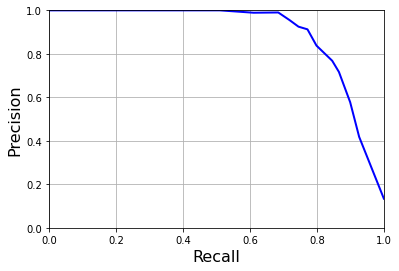

In [27]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba)
plot_precision_vs_recall(precisions, recalls)

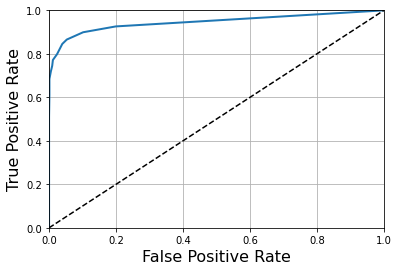

In [28]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
plot_roc_curve(fpr, tpr)

KNN не слишком хорош в плане пояснения важности признаков, тут ничего не сказать.

# Model creation

Для остальных двух методов построим реальный pipeline.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer

class PipelineModel:
    
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y):
        self.pipeline_model = Pipeline([('vect', CountVectorizer()),
                                        ('clf', self.model)])
        self.named_steps = self.pipeline_model.named_steps
    
        self.pipeline_model.fit(X, y)
    
    def predict(self, X):
        return self.pipeline_model.predict(X)
    
    def predict_proba(self, X):
        return self.pipeline_model.predict_proba(X)

# Logistic Regression solution

In [30]:
X, y = df.message, df.mark
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = PipelineModel(LogisticRegression(solver="liblinear", random_state=42))
model.fit(X_train, y_train)

In [31]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

In [32]:
weights = sorted(list(zip(model.named_steps.clf.coef_[0], model.named_steps.vect.get_feature_names())), key=lambda x: abs(x[0]), reverse=True)
top_spam_words = list(map(lambda x: x[1], filter(lambda x: x[0] > 0, weights)))[:15]
top_ham_words = list(map(lambda x: x[1], filter(lambda x: x[0] < 0, weights)))[:15]

In [33]:
top_spam_words

['txt',
 'servic',
 'claim',
 'uk',
 'chat',
 'new',
 'rington',
 'text',
 'call',
 'cash',
 'repli',
 'prize',
 'urgent',
 'win',
 'mobil']

In [34]:
top_ham_words

['later',
 'say',
 'sir',
 'happi',
 'da',
 'amp',
 'ok',
 'home',
 'way',
 'got',
 'might',
 'said',
 'work',
 'hope',
 'finish']

Ну получили что-то похожее на правду: наибольший положительный вес в то, что сообщение является спамом дают слова `prize`, `cash`, `cost`, `rington`, а наибольший отрицательный дают обычные разговорные слова `sir`, `ok`, `got`, `pls`

In [35]:
print_stats(y_test, y_pred)

Confusion Matrix: 
 [[962   2]
 [ 17 131]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       964
           1       0.98      0.89      0.93       148

    accuracy                           0.98      1112
   macro avg       0.98      0.94      0.96      1112
weighted avg       0.98      0.98      0.98      1112

Accuracy: 98.29%
Precision: 98.50%
Recall: 88.51%


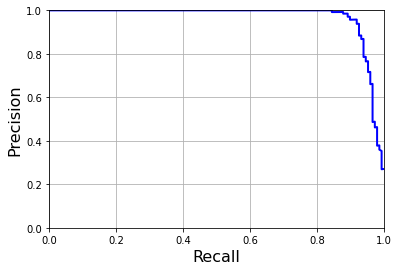

In [36]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba)
plot_precision_vs_recall(precisions, recalls)

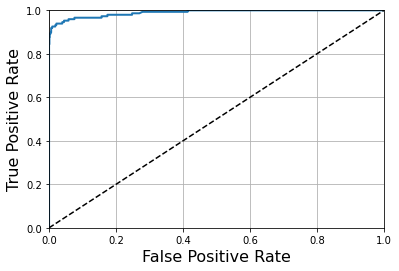

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
plot_roc_curve(fpr, tpr)

# Random Forest solution

In [38]:
from sklearn.ensemble import RandomForestClassifier

X, y = df.message, df.mark
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = PipelineModel(RandomForestClassifier(n_estimators=200))
model.fit(X_train, y_train)

In [39]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

In [40]:
print_stats(y_test, y_pred)

Confusion Matrix: 
 [[963   1]
 [ 27 121]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       964
           1       0.99      0.82      0.90       148

    accuracy                           0.97      1112
   macro avg       0.98      0.91      0.94      1112
weighted avg       0.98      0.97      0.97      1112

Accuracy: 97.48%
Precision: 99.18%
Recall: 81.76%


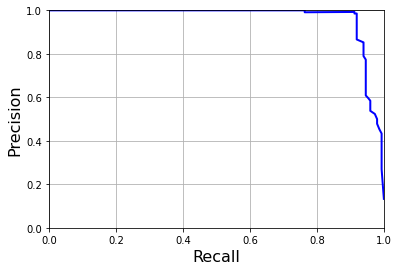

In [41]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba)
plot_precision_vs_recall(precisions, recalls)

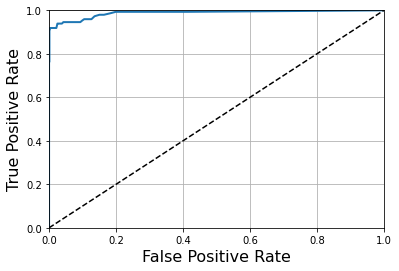

In [42]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
plot_roc_curve(fpr, tpr)

In [43]:
weights = sorted(list(zip(model.pipeline_model.named_steps.clf.feature_importances_, model.named_steps.vect.get_feature_names())), key=lambda x: abs(x[0]), reverse=True)
top_important_words = list(map(lambda x: x[1], filter(lambda x: x[0] > 0, weights)))[:20]

In [44]:
top_important_words

['txt',
 'call',
 'claim',
 'free',
 'mobil',
 'servic',
 'prize',
 'text',
 'uk',
 'repli',
 'nokia',
 'tone',
 'stop',
 'award',
 'urgent',
 'win',
 'cash',
 'contact',
 'collect',
 'custom']

А здесь просто наиболее важные слова, по которым больше и лучше всего сплитились деревья решений. Видно, что тут есть как и spam-слова, так и ham-слова.

# Inference

Что получилось понять: есть хороший пайплайн для обучения и тестирования моделей (по крайней мере estimator-ов & predictor-ов), можно закинуть любую модель, всё будет работать.

На основании выходов можно узнать список слов, присутствие и отсутствие которых в сообщениии является очень важным при классификации на spam/ham. По сути, можно отдать эти слова как фичи в ещё одну модель, например стакнув Random Forest и KNN.

Что я могу проинтерпретировать судя по метрикам: векторизация учитывает больше (в логистической регрессии и в случайном лесу), чем наивная частота самых частых слов (в KNN).
